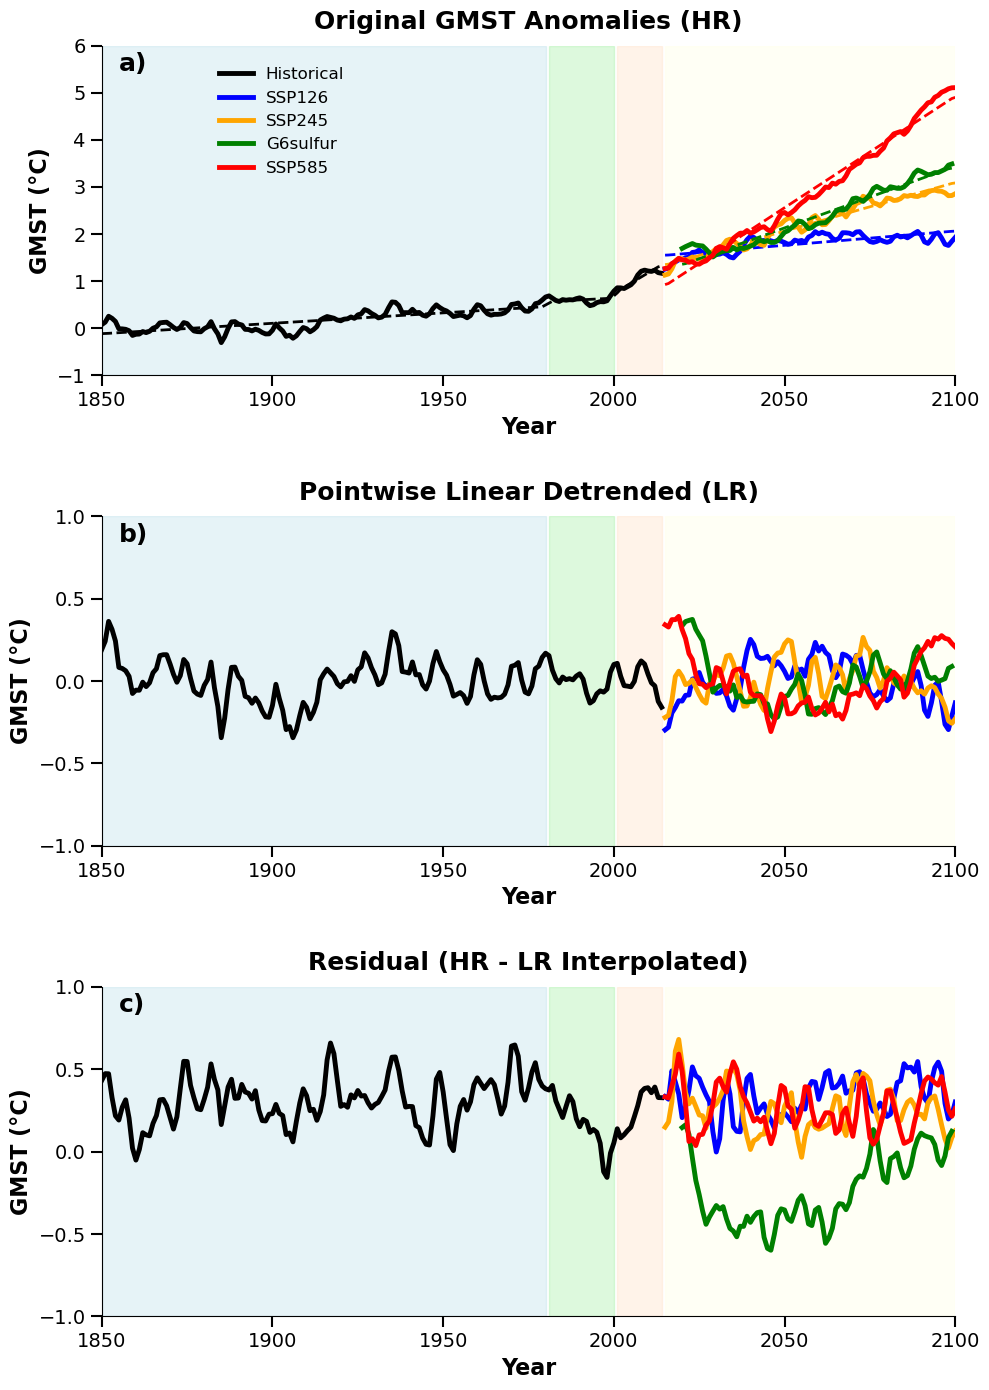

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import xarray as xr
from pathlib import Path

# Load data
data_dir = Path("../data")
figures_dir = Path("../Figures")
figures_dir.mkdir(exist_ok=True)

ds_hist = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_historical_r1i1p1f1_1850_2014_allvars.nc")
ds_ssp126 = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_ssp126_r1i1p1f1_2015_2100_allvars.nc")
ds_ssp245 = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_ssp245_r1i1p1f1_2015_2100_allvars.nc")
ds_ssp585 = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_ssp585_r1i1p1f1_2015_2100_allvars.nc")
ds_g6sulfur = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_g6sulfur_r1i1p1f1_2020_2099_allvars.nc")

# Define time periods for detrending
time_periods = [
    (1850, 1980),
    (1981, 2000),
    (2001, 2014),
    (2015, 2100)
]

# Define time periods for shading
shade_periods = [
    (1850, 1980, 'lightblue', 0.3),
    (1981, 2000, 'lightgreen', 0.3),
    (2001, 2014, 'peachpuff', 0.3),
    (2015, 2100, 'lightyellow', 0.3)
]

def pointwise_linear_detrend(data_3d, years, time_periods):
    """Pointwise Linear Detrend (PLD)"""
    n_time, n_lat, n_lon = data_3d.shape
    detrended_data = np.zeros_like(data_3d)
    fitted_trends = np.zeros_like(data_3d)
    
    for start_year, end_year in time_periods:
        mask = (years >= start_year) & (years <= end_year)
        time_indices = np.where(mask)[0]
        
        if len(time_indices) == 0:
            continue
        
        period_data = data_3d[mask, :, :]
        n_time_period = period_data.shape[0]
        t = np.arange(n_time_period).astype(float)
        data_reshaped = period_data.reshape(n_time_period, -1)
        
        t_mean = np.mean(t)
        data_mean = np.mean(data_reshaped, axis=0)
        
        t_centered = t - t_mean
        data_centered = data_reshaped - data_mean
        
        numerator = np.sum(t_centered[:, np.newaxis] * data_centered, axis=0)
        denominator = np.sum(t_centered**2)
        
        b = numerator / denominator
        a = data_mean - b * t_mean
        
        trend = a[np.newaxis, :] + b[np.newaxis, :] * t[:, np.newaxis]
        residuals = data_reshaped - trend
        
        residuals_3d = residuals.reshape(n_time_period, n_lat, n_lon)
        trend_3d = trend.reshape(n_time_period, n_lat, n_lon)
        
        detrended_data[mask, :, :] = residuals_3d
        fitted_trends[mask, :, :] = trend_3d
    
    return detrended_data, fitted_trends

def to_annual_mean(data, years):
    """Convert to annual averages"""
    df = pd.DataFrame({'year': years, 'value': data})
    annual = df.groupby('year')['value'].mean()
    return annual.index.values, annual.values

def smooth_data(data, window=3):
    """Apply rolling mean"""
    df = pd.Series(data)
    smoothed = df.rolling(window=window, center=True, min_periods=1).mean()
    return smoothed.values

# Variables
var_hr = 'tas_hr'
var_lr = 'tas_lr_interp'

# Calculate baseline (1850-1900)
baseline_start, baseline_end = 1850, 1900
tas_hist_hr = ds_hist[var_hr]
years_hist = ds_hist.time.dt.year
mask_baseline = (years_hist >= baseline_start) & (years_hist <= baseline_end)
baseline_data = tas_hist_hr.isel(time=mask_baseline)
baseline = baseline_data.mean(dim=['time', 'lat', 'lon']).values

# Create 3x1 figure
fig, axes = plt.subplots(3, 1, figsize=(10, 14))

# Colors for scenarios
colors = {
    'historical': 'black',
    'ssp126': 'blue',
    'ssp245': 'orange',
    'g6sulfur': 'green',
    'ssp585': 'red'
}

# Labels for scenarios
labels = {
    'historical': 'Historical',
    'ssp126': 'SSP126',
    'ssp245': 'SSP245',
    'g6sulfur': 'G6sulfur',
    'ssp585': 'SSP585'
}

# Panel labels
panel_labels = ['a)', 'b)', 'c)']

scenarios = [
    ('historical', ds_hist),
    ('ssp126', ds_ssp126),
    ('ssp245', ds_ssp245),
    ('g6sulfur', ds_g6sulfur),
    ('ssp585', ds_ssp585)
]

for scenario_name, ds in scenarios:
    # Get HR and LR temperature data
    tas_hr_data = ds[var_hr].values
    tas_lr_data = ds[var_lr].values
    years = ds.time.dt.year.values
    
    # Calculate HR anomalies
    hr_anomaly_data = tas_hr_data - baseline
    
    # Calculate residual (HR - LR)
    residual_data = tas_hr_data - tas_lr_data
    
    # Apply PLD detrending to HR anomalies
    detrended_pld, fitted_trends_pld = pointwise_linear_detrend(hr_anomaly_data, years, time_periods)
    
    # Calculate global means
    global_mean_hr_anomaly = np.mean(hr_anomaly_data, axis=(1, 2))
    global_mean_fitted_pld = np.mean(fitted_trends_pld, axis=(1, 2))
    global_mean_detrended_pld = np.mean(detrended_pld, axis=(1, 2))
    global_mean_residual = np.mean(residual_data, axis=(1, 2))  # HR - LR residual
    
    # Convert to annual averages
    annual_years_orig, annual_mean_orig = to_annual_mean(global_mean_hr_anomaly, years)
    annual_years_trend, annual_fitted_trend = to_annual_mean(global_mean_fitted_pld, years)
    annual_years_detr, annual_mean_detr = to_annual_mean(global_mean_detrended_pld, years)
    annual_years_resid, annual_mean_resid = to_annual_mean(global_mean_residual, years)
    
    # Apply smoothing
    window = 3
    smoothed_original = smooth_data(annual_mean_orig, window)
    smoothed_trend = smooth_data(annual_fitted_trend, window)
    smoothed_detrended = smooth_data(annual_mean_detr, window)
    smoothed_residual = smooth_data(annual_mean_resid, window)
    
    color = colors[scenario_name]
    
    # Panel 0: Original HR GMST anomaly with fitted trend
    axes[0].plot(annual_years_orig, smoothed_original, color=color,
                linewidth=3.5, alpha=1, label=labels[scenario_name])
    axes[0].plot(annual_years_trend, smoothed_trend, color=color,
                linewidth=2, alpha=1, linestyle='--')
    
    # Panel 1: PLD detrended
    axes[1].plot(annual_years_detr, smoothed_detrended, color=color,
                linewidth=3.5, alpha=1, label=labels[scenario_name])
    
    # Panel 2: Residual (HR - LR)
    axes[2].plot(annual_years_resid, smoothed_residual, color=color,
                linewidth=3.5, alpha=1, label=labels[scenario_name])

# Format panels
titles = [
    'Original GMST Anomalies (HR)',
    'Pointwise Linear Detrended (LR)',
    'Residual (HR - LR Interpolated)'
]

ylims = [(-1, 6), (-1, 1), (-1, 1)]
yticks = [
    np.arange(-1, 7, 1),
    np.arange(-1, 1.5, 0.5),
    np.arange(-1, 1.5, 0.5)
]

xticks = [1850, 1900, 1950, 2000, 2050, 2100]

for idx, ax in enumerate(axes):
    # Add shading
    for start_year, end_year, color_shade, alpha in shade_periods:
        ax.axvspan(start_year, end_year, color=color_shade, alpha=alpha, zorder=0)
    
    # Set limits and ticks
    ax.set_ylim(ylims[idx])
    ax.set_yticks(yticks[idx])
    ax.set_xlim(1850, 2100)
    ax.set_xticks(xticks)
    
    # Labels
    ax.set_ylabel('GMST (°C)', fontsize=16, fontweight='bold')
    ax.set_xlabel('Year', fontsize=16, fontweight='bold')
    ax.set_title(titles[idx], fontsize=18, fontweight='bold', pad=12)
    
    # Panel label
    ax.text(0.02, 0.98, panel_labels[idx],
           transform=ax.transAxes,
           fontsize=18, fontweight='bold',
           va='top', ha='left')
    
    # Legend (only first panel)
    if idx == 0:
        ax.legend(loc='upper left', bbox_to_anchor=(0.12, 0.98), fontsize=12, frameon=False)
    
    # Spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Tick parameters
    ax.tick_params(labelsize=14, length=8, width=1.5)


plt.tight_layout(h_pad=3.0) 

# Save figure
output_file = figures_dir / "temporal_evolution.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')

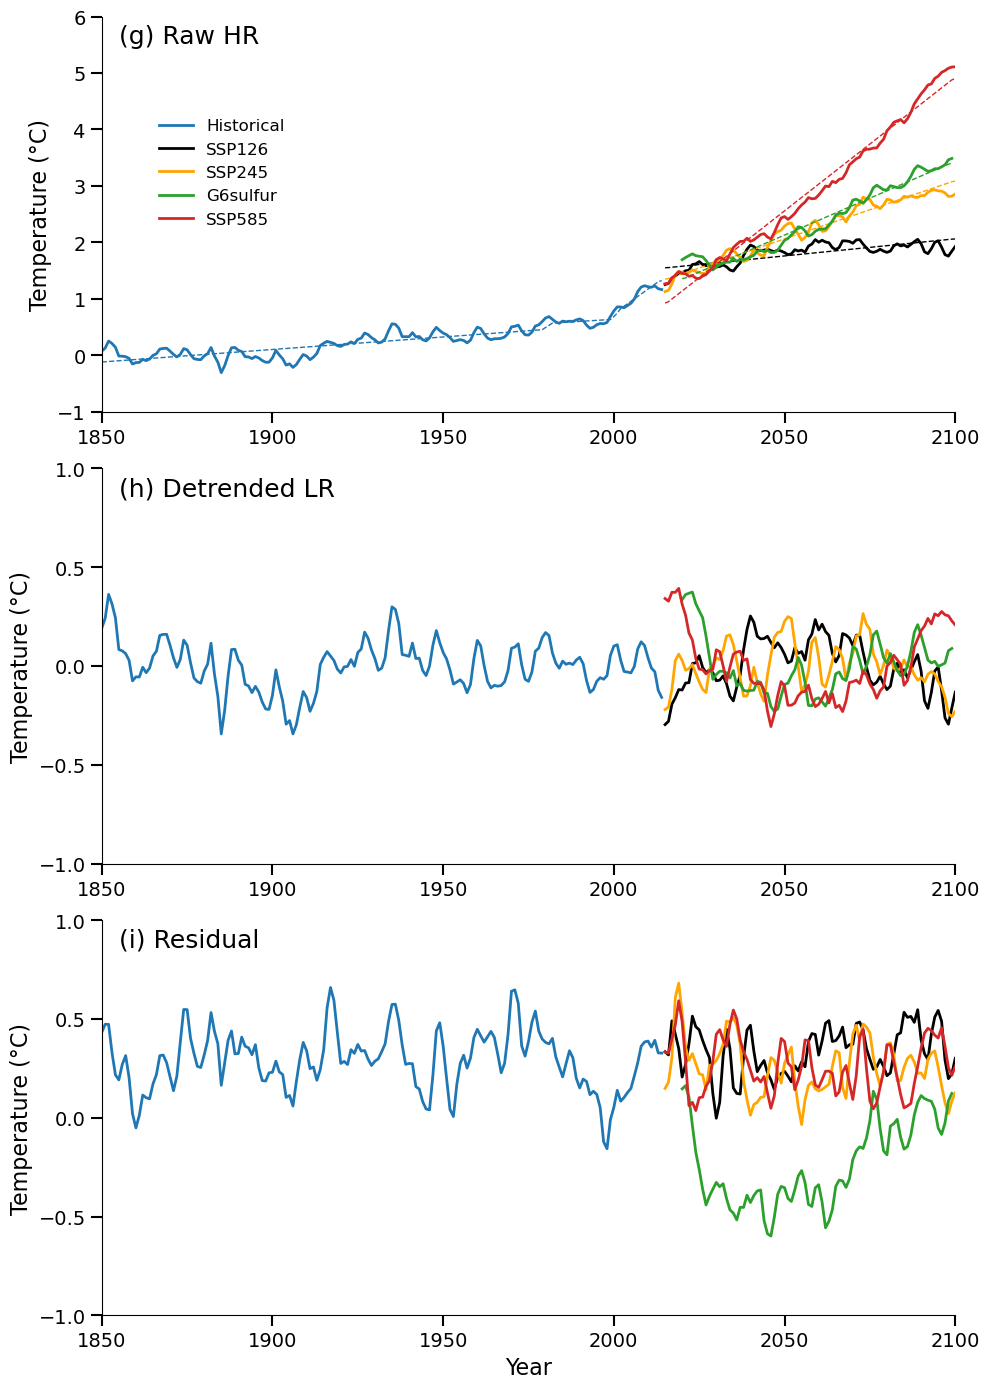

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import xarray as xr
from pathlib import Path

# Load data
data_dir = Path("../data")
figures_dir = Path("../Figures")
figures_dir.mkdir(exist_ok=True)

ds_hist = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_historical_r1i1p1f1_1850_2014_allvars.nc")
ds_ssp126 = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_ssp126_r1i1p1f1_2015_2100_allvars.nc")
ds_ssp245 = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_ssp245_r1i1p1f1_2015_2100_allvars.nc")
ds_ssp585 = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_ssp585_r1i1p1f1_2015_2100_allvars.nc")
ds_g6sulfur = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_g6sulfur_r1i1p1f1_2020_2099_allvars.nc")

# Define time periods for detrending
time_periods = [
    (1850, 1980),
    (1981, 2000),
    (2001, 2014),
    (2015, 2100)
]

def pointwise_linear_detrend(data_3d, years, time_periods):
    """Pointwise Linear Detrend (PLD)"""
    n_time, n_lat, n_lon = data_3d.shape
    detrended_data = np.zeros_like(data_3d)
    fitted_trends = np.zeros_like(data_3d)
    
    for start_year, end_year in time_periods:
        mask = (years >= start_year) & (years <= end_year)
        time_indices = np.where(mask)[0]
        
        if len(time_indices) == 0:
            continue
        
        period_data = data_3d[mask, :, :]
        n_time_period = period_data.shape[0]
        t = np.arange(n_time_period).astype(float)
        data_reshaped = period_data.reshape(n_time_period, -1)
        
        t_mean = np.mean(t)
        data_mean = np.mean(data_reshaped, axis=0)
        
        t_centered = t - t_mean
        data_centered = data_reshaped - data_mean
        
        numerator = np.sum(t_centered[:, np.newaxis] * data_centered, axis=0)
        denominator = np.sum(t_centered**2)
        
        b = numerator / denominator
        a = data_mean - b * t_mean
        
        trend = a[np.newaxis, :] + b[np.newaxis, :] * t[:, np.newaxis]
        residuals = data_reshaped - trend
        
        residuals_3d = residuals.reshape(n_time_period, n_lat, n_lon)
        trend_3d = trend.reshape(n_time_period, n_lat, n_lon)
        
        detrended_data[mask, :, :] = residuals_3d
        fitted_trends[mask, :, :] = trend_3d
    
    return detrended_data, fitted_trends

def to_annual_mean(data, years):
    """Convert to annual averages"""
    df = pd.DataFrame({'year': years, 'value': data})
    annual = df.groupby('year')['value'].mean()
    return annual.index.values, annual.values

def smooth_data(data, window=3):
    """Apply rolling mean"""
    df = pd.Series(data)
    smoothed = df.rolling(window=window, center=True, min_periods=1).mean()
    return smoothed.values

# Variables
var_hr = 'tas_hr'
var_lr = 'tas_lr_interp'

# Calculate baseline (1850-1900)
baseline_start, baseline_end = 1850, 1900
tas_hist_hr = ds_hist[var_hr]
years_hist = ds_hist.time.dt.year
mask_baseline = (years_hist >= baseline_start) & (years_hist <= baseline_end)
baseline_data = tas_hist_hr.isel(time=mask_baseline)
baseline = baseline_data.mean(dim=['time', 'lat', 'lon']).values

# Create 3x1 figure
fig, axes = plt.subplots(3, 1, figsize=(10, 14))

# Colors for scenarios - matching distribution shift colors
colors = {
    'historical': '#1f77b4',  # Blue
    'ssp126': 'black',
    'ssp245': 'orange',
    'g6sulfur': '#2ca02c',  # Green
    'ssp585': '#d62728'  # Red
}

# Labels for scenarios
labels = {
    'historical': 'Historical',
    'ssp126': 'SSP126',
    'ssp245': 'SSP245',
    'g6sulfur': 'G6sulfur',
    'ssp585': 'SSP585'
}

# Panel labels
panel_labels = ['(g) Raw HR', '(h) Detrended LR', '(i) Residual']

scenarios = [
    ('historical', ds_hist),
    ('ssp126', ds_ssp126),
    ('ssp245', ds_ssp245),
    ('g6sulfur', ds_g6sulfur),
    ('ssp585', ds_ssp585)
]

for scenario_name, ds in scenarios:
    # Get HR and LR temperature data
    tas_hr_data = ds[var_hr].values
    tas_lr_data = ds[var_lr].values
    years = ds.time.dt.year.values
    
    # Calculate HR anomalies
    hr_anomaly_data = tas_hr_data - baseline
    
    # Calculate residual (HR - LR)
    residual_data = tas_hr_data - tas_lr_data
    
    # Apply PLD detrending to HR anomalies
    detrended_pld, fitted_trends_pld = pointwise_linear_detrend(hr_anomaly_data, years, time_periods)
    
    # Calculate global means
    global_mean_hr_anomaly = np.mean(hr_anomaly_data, axis=(1, 2))
    global_mean_fitted_pld = np.mean(fitted_trends_pld, axis=(1, 2))
    global_mean_detrended_pld = np.mean(detrended_pld, axis=(1, 2))
    global_mean_residual = np.mean(residual_data, axis=(1, 2))  # HR - LR residual
    
    # Convert to annual averages
    annual_years_orig, annual_mean_orig = to_annual_mean(global_mean_hr_anomaly, years)
    annual_years_trend, annual_fitted_trend = to_annual_mean(global_mean_fitted_pld, years)
    annual_years_detr, annual_mean_detr = to_annual_mean(global_mean_detrended_pld, years)
    annual_years_resid, annual_mean_resid = to_annual_mean(global_mean_residual, years)
    
    # Apply smoothing
    window = 3
    smoothed_original = smooth_data(annual_mean_orig, window)
    smoothed_trend = smooth_data(annual_fitted_trend, window)
    smoothed_detrended = smooth_data(annual_mean_detr, window)
    smoothed_residual = smooth_data(annual_mean_resid, window)
    
    color = colors[scenario_name]
    
    # Panel 0: Original HR GMST anomaly with fitted trend
    axes[0].plot(annual_years_orig, smoothed_original, color=color,
                linewidth=2, alpha=1, label=labels[scenario_name])
    axes[0].plot(annual_years_trend, smoothed_trend, color=color,
                linewidth=1, alpha=1, linestyle='--')
    
    # Panel 1: PLD detrended
    axes[1].plot(annual_years_detr, smoothed_detrended, color=color,
                linewidth=2, alpha=1, label=labels[scenario_name])
    
    # Panel 2: Residual (HR - LR)
    axes[2].plot(annual_years_resid, smoothed_residual, color=color,
                linewidth=2, alpha=1, label=labels[scenario_name])

# Format panels
ylims = [(-1, 6), (-1, 1), (-1, 1)]
yticks = [
    np.arange(-1, 7, 1),
    np.arange(-1, 1.5, 0.5),
    np.arange(-1, 1.5, 0.5)
]

xticks = [1850, 1900, 1950, 2000, 2050, 2100]

for idx, ax in enumerate(axes):
    # Set limits and ticks
    ax.set_ylim(ylims[idx])
    ax.set_yticks(yticks[idx])
    ax.set_xlim(1850, 2100)
    ax.set_xticks(xticks)
    
    # Y-axis label on all rows (not bold)
    ax.set_ylabel('Temperature (°C)', fontsize=16)
    
    # X-axis label only on last row (not bold)
    if idx == 2:
        ax.set_xlabel('Year', fontsize=16)
    
    # Panel label
    ax.text(0.02, 0.98, panel_labels[idx],
           transform=ax.transAxes,
           fontsize=18,
           va='top', ha='left')
    
    # Legend (only first panel)
    if idx == 0:
        ax.legend(loc='upper left', bbox_to_anchor=(0.05, 0.78), fontsize=12, frameon=False)
    
    # Spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Tick parameters
    ax.tick_params(labelsize=14, length=8, width=1.5)

# Reduce spacing between rows
plt.tight_layout(h_pad=1.0) 

# Save figure
output_file = figures_dir / "temporal_evolution.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()